# Model testing against jitter scan data
This notebook reads data from a jitter simulation scan and fits GP models to key quantities.
The models are used to perform additional jitter analysis

#### Reads data and fit model

In [1]:
import pandas as pd
import numpy as np
from libe_opt_postproc.ax_model_manager import AxModelManager
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad

# reads data
df = pd.read_csv('./data/scan_data.csv')
print(list(df.columns))
varpars = ['laser_dE', 'laser_dzfoc', 'laser_dtau', 'laser_dT', 'laser_dx', 'laser_dy', 'beam_theta_x', 'beam_theta_y']

['Unnamed: 0', 'x_avg', 'y_avg', 'z_avg', 'theta_x', 'theta_y', 'sigma_x', 'sigma_y', 'sigma_z', 'z_fwhm', 'sigma_px', 'sigma_py', 'alpha_x', 'alpha_y', 'beta_x', 'beta_y', 'gamma_x', 'gamma_y', 'emitt_nx', 'emitt_ny', 'emitt_nx_sl', 'emitt_ny_sl', 'ene_avg', 'rel_ene_sp', 'rel_ene_sp_sl', 'i_peak', 'q', 'laser_dE', 'laser_dzfoc', 'laser_dtau', 'laser_dT', 'laser_dx', 'laser_dy', 'beam_theta_x', 'beam_theta_y']


[INFO 09-20 11:32:08] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='laser_dE', parameter_type=FLOAT, range=[-1.3320629696310695, 1.1043308149905544]), RangeParameter(name='laser_dzfoc', parameter_type=FLOAT, range=[-301.6031985209298, 343.2663431795559]), RangeParameter(name='laser_dtau', parameter_type=FLOAT, range=[-2.698361741666047, 3.0308571123720305]), RangeParameter(name='laser_dT', parameter_type=FLOAT, range=[-11.645205612135028, 18.701244518522945]), RangeParameter(name='laser_dx', parameter_type=FLOAT, range=[-15.320706780525503, 16.605393780851823]), RangeParameter(name='laser_dy', parameter_type=FLOAT, range=[-13.954982033469232, 19.793013520189817]), RangeParameter(name='beam_theta_x', parameter_type=FLOAT, range=[-1.2067515005868938, 1.1950729811667558]), RangeParameter(name='beam_theta_y', parameter_type=FLOAT, range=[-1.5766787250955243, 1.413649897029825])], parameter_constraints=[]).


Plotting the model in the laser_dT vs laser_dzfoc plane


[INFO 09-20 11:32:18] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='laser_dE', parameter_type=FLOAT, range=[-1.3320629696310695, 1.1043308149905544]), RangeParameter(name='laser_dzfoc', parameter_type=FLOAT, range=[-301.6031985209298, 343.2663431795559]), RangeParameter(name='laser_dtau', parameter_type=FLOAT, range=[-2.698361741666047, 3.0308571123720305]), RangeParameter(name='laser_dT', parameter_type=FLOAT, range=[-11.645205612135028, 18.701244518522945]), RangeParameter(name='laser_dx', parameter_type=FLOAT, range=[-15.320706780525503, 16.605393780851823]), RangeParameter(name='laser_dy', parameter_type=FLOAT, range=[-13.954982033469232, 19.793013520189817]), RangeParameter(name='beam_theta_x', parameter_type=FLOAT, range=[-1.2067515005868938, 1.1950729811667558]), RangeParameter(name='beam_theta_y', parameter_type=FLOAT, range=[-1.5766787250955243, 1.413649897029825])], parameter_constraints=[]).


Plotting the model in the laser_dT vs laser_dzfoc plane


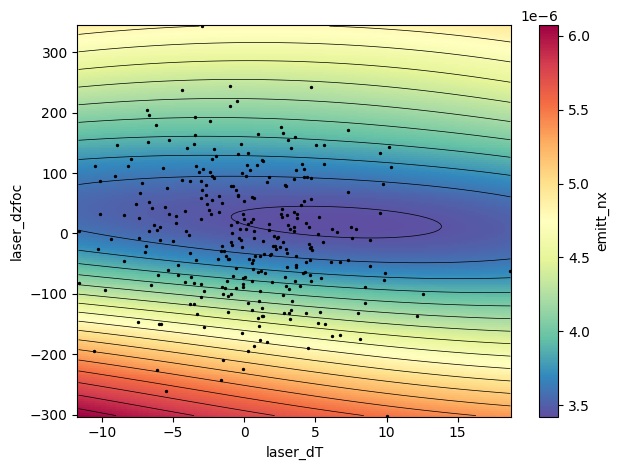

In [2]:
metrics = ['ene_avg', 'emitt_nx']
models = dict.fromkeys(metrics)
for k in models.keys():
    models[k] = AxModelManager(df)
    models[k].build_model(parnames=varpars, objname=k)
    models[k].plot_model(xname='laser_dT', yname='laser_dzfoc', cmap='Spectral_r');

#### Sets the corresponding jitter values of the scan
These are the original jitters used in the creation of the data file 

In [3]:
# varying parameters: central values and jitters (rms)
values   = [0.0,   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jitters  = [0.5, 100.0, 1.0, 5.0, 5.0, 5.0, 0.5, 0.5]
parvals  = dict(zip(varpars, values))
parjits  = dict(zip(varpars, jitters))

#### Create a random sample according to the given jitters

In [4]:
sample = np.random.normal(size=[10000, len(parvals)]) 
for i, var in enumerate(varpars): 
    sample[:, i] = parvals[var] + parjits[var] * sample[:, i]
sample = pd.DataFrame(sample, columns=varpars) 

#### Evaluate the model for the average energy throughout the sample and compares with the direct result of the scan

average ene_avg = 963.619 +- 0.125%
average ene_avg = 963.682 +- 0.120%


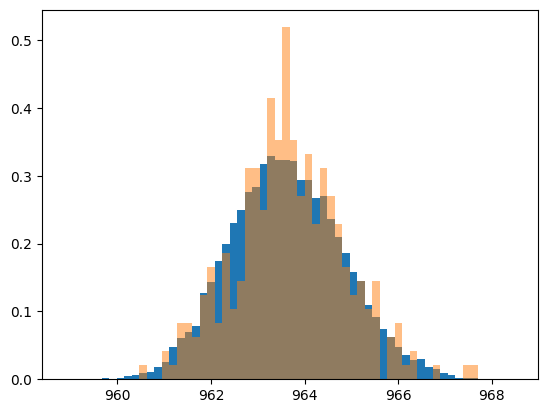

In [5]:
ene, _ = models['ene_avg'].evaluate_model(sample, p0=parvals) 

mean_ene_avg = df['ene_avg'].mean()
plt.hist(ene, bins=60, range=[mean_ene_avg * 0.995, mean_ene_avg * 1.005], density=True);
print('average %s = %.3f +- %.3f%%' % ('ene_avg', np.average(ene), 100 * np.std(ene) / mean_ene_avg))
plt.hist(df['ene_avg'], bins=60, range=[mean_ene_avg * 0.995, mean_ene_avg * 1.005], density=True, alpha=0.5);
print('average %s = %.3f +- %.3f%%' % ('ene_avg', np.average(df['ene_avg']), 100 * np.std(df['ene_avg']) / mean_ene_avg))

#### Varies only one parameter at a time (fixing the rest)
The model allows for independent evaluation of individual jitters

var = laser_dE -> average ene_avg = 9.631e+02 +- 0.022%
var = laser_dzfoc -> average ene_avg = 9.636e+02 +- 0.062%
var = laser_dtau -> average ene_avg = 9.631e+02 +- 0.044%
var = laser_dT -> average ene_avg = 9.631e+02 +- 0.104%
var = laser_dx -> average ene_avg = 9.630e+02 +- 0.014%
var = laser_dy -> average ene_avg = 9.630e+02 +- 0.012%
var = beam_theta_x -> average ene_avg = 9.631e+02 +- 0.006%
var = beam_theta_y -> average ene_avg = 9.631e+02 +- 0.004%


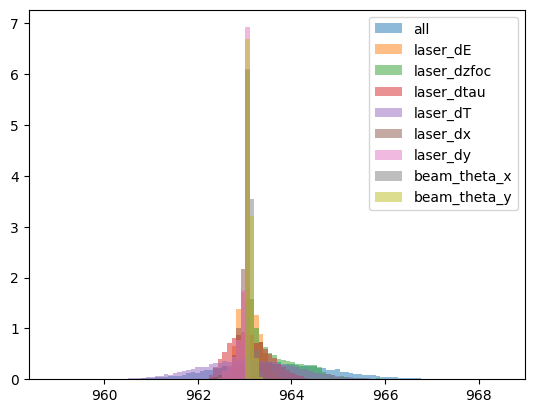

In [6]:
fig = plt.figure(dpi=100)
plt.hist(ene, bins=100, range=[mean_ene_avg * 0.995, mean_ene_avg * 1.005], density=True, alpha=0.5, label='all')
for k in varpars:
    ene, _ = models['ene_avg'].evaluate_model(sample[[k]], p0=parvals) 
    plt.hist(ene, bins=100, range=[mean_ene_avg * 0.995, mean_ene_avg * 1.005], density=True, alpha=0.5, label=k);
    print('var = %s -> average %s = %.3e +- %.3f%%' % (k, 'ene_avg', np.average(ene), 100 * np.std(ene) / mean_ene_avg))
plt.legend(loc='upper right');

The contribution of the timing jitter is the dominant one

#### Now the emittance

average emitt_nx = 5.581e-06 +- 18.802%
average emitt_nx = 5.666e-06 +- 21.082%


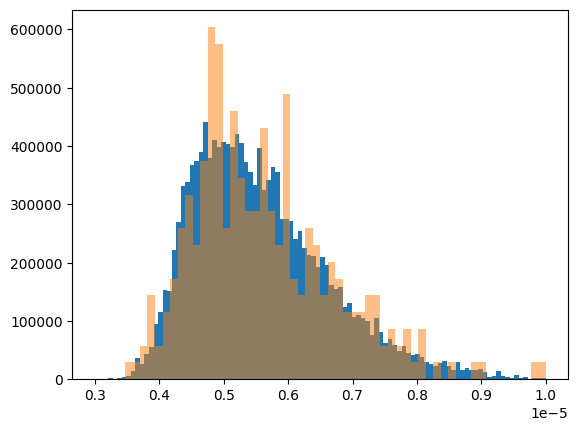

In [7]:
emitt, _ = models['emitt_nx'].evaluate_model(sample, p0=parvals) 

mean_emitt_nx = df['emitt_nx'].mean()
plt.hist(emitt, bins=100, range=[3e-6, 10e-6], density=True);
print('average %s = %.3e +- %.3f%%' % ('emitt_nx', np.average(emitt), 100 * np.std(emitt) / mean_emitt_nx))
plt.hist(df['emitt_nx'], bins=60, range=[3e-6, 10e-6], density=True, alpha=0.5);
print('average %s = %.3e +- %.3f%%' % ('emitt_nx', np.average(df['emitt_nx']), 100 * np.std(df['emitt_nx']) / mean_emitt_nx))

var = laser_dE -> average emitt_nx = 4.543e-06 +- 5.512%
var = laser_dzfoc -> average emitt_nx = 4.820e-06 +- 9.773%
var = laser_dtau -> average emitt_nx = 4.589e-06 +- 7.742%
var = laser_dT -> average emitt_nx = 4.517e-06 +- 0.613%
var = laser_dx -> average emitt_nx = 5.057e-06 +- 11.990%
var = laser_dy -> average emitt_nx = 4.483e-06 +- 0.782%
var = beam_theta_x -> average emitt_nx = 4.768e-06 +- 6.144%
var = beam_theta_y -> average emitt_nx = 4.421e-06 +- 2.092%


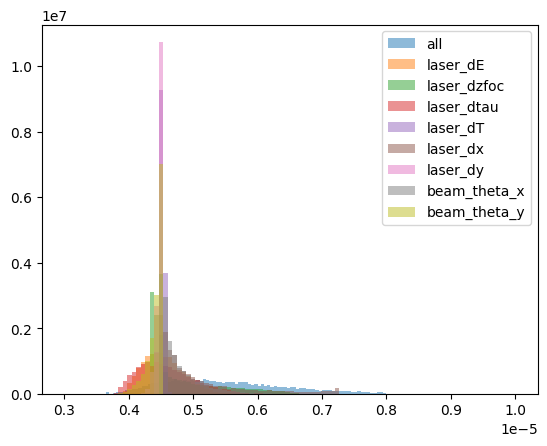

In [8]:
fig = plt.figure(dpi=100)
plt.hist(emitt, bins=100, range=[3e-6, 8e-6], density=True, alpha=0.5, label='all')
for k in varpars:
    emitt, _ = models['emitt_nx'].evaluate_model(sample[[k]], p0=parvals) 
    plt.hist(emitt, bins=100, range=[3e-6, 10e-6], density=True, alpha=0.5, label=k);
    print('var = %s -> average %s = %.3e +- %.3f%%' % (k, 'emitt_nx', np.average(emitt), 100 * np.std(emitt) / mean_emitt_nx))
plt.legend(loc='upper right');

Most significant contribution to the emittance comes from the laser misalignment.
Followed by the laser focal position jitter (??)